# Geodata.cutout updates

### Jeffrey Feng, 8/16/2021

A short guide to use the product of mask module for masking cutout objects.

## 1. Introduction

Geodata is able to process geospatial data to extract cutouts over specified geographies. Built off the [rasterio library](https://rasterio.readthedocs.io/en/latest/quickstart.html), the mask module imports rasters and shapefiles, merges and flattens multiple layers together, and extracts subsetted cutout data from merged masks and shapefiles.

The sample workflow that shows how to create a mask object and save it to the disk can be found in `mask_creation_workflow.md` and [mask_test.ipynb](https://github.com/east-winds/geodata/tree/mask/tests/mask_test.ipynb).

## 2. Setup

To start, import the required dependencies:

In [1]:
import geodata
import xarray as xr

To launch a logger for detailed debugging, run:

In [2]:
import logging
logging.basicConfig(level=logging.INFO)

We will use a cutout object created through:

In [6]:
DS_monthly_chn = geodata.Dataset(module="merra2",
                                 years=slice(2011, 2011),month=slice(1,12),weather_data_config = "slv_radiation_monthly")
if DS_monthly_chn.prepared == False: DS_monthly_chn.get_data()
DS_monthly_chn.trim_variables()
cutout = geodata.Cutout(name = "china-2011-slv-test",module = "merra2",weather_data_config = "slv_radiation_monthly",
                        xs = slice(73, 136),ys = slice(18, 54),years = slice(2011, 2011), months = slice(1,12))
cutout.prepare()

INFO:geodata.dataset:No months specified, defaulting to 1-12
INFO:geodata.dataset:Using global bounds.
INFO:geodata.dataset:Directory D:/Users/davison_lab_data/merra2 found, checking for completeness.
INFO:geodata.dataset:Directory complete.
INFO:geodata.cutout:All cutout (china-2011-slv-test, D:/Users/davison_lab_data/cutouts) files available.
INFO:geodata.cutout:Cutout subset prepared: <Cutout china-2011-slv-test x=73.12-135.62 y=18.00-54.00 time=2011/1-2011/12 prepared>
INFO:geodata.preparation:The cutout is already prepared. If you want to recalculate it, supply an `overwrite=True` argument.


True

## 3. Loading mask

**NOTE:** 

If you have created the mask `china_bin`, please ignore the block below, and run the next section. Otherwise, un-comment the cell below and run it.

In [3]:
# prov_path = shpreader.natural_earth(resolution='10m', category='cultural', name = 'admin_1_states_provinces')
# china_all_shapes = geodata.mask.get_shape(prov_path, key = 'name_en', return_dict = True,
#                          condition_key = 'admin', condition_value = 'China')
# # #get rid of the islands, EDGE CASE cuz the islands are outside of shape
# china_all_shapes.pop(None) 

# china_bin = geodata.Mask("china_bin")
# china_bin.add_layer('FINAL_GRID_5BINS.tif', layer_name = 'bins')

# #extracted shape on bins layer
# china_bin.extract_shapes(china_all_shapes, layer = 'bins')
# china_bin.save_mask()

If the user have already created such mask object on disk, it is sufficient to run the following cell to retrieve the object:

In [4]:
china_bin = geodata.mask.load_mask("china_bin")

INFO:geodata.mask:Layer ['bins'] loaded to the mask china_bin.
INFO:geodata.mask:No Merged Mask found.
INFO:geodata.mask:Shape mask ['Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong', 'Guangxi Zhuang Autonomous Region', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan', 'Hubei', 'Hunan', 'Inner Mongolia', 'Jiangsu', 'Jiangxi', 'Jilin', 'Liaoning', 'Ningxia Hui Autonomous Region', 'Qinghai', 'Shaanxi', 'Shandong', 'Shanghai', 'Shanxi', 'Sichuan', 'Tianjin', 'Tibet', 'Xinjiang', 'Yunnan', 'Zhejiang'] loaded to the mask china_bin.


## 4. Adding Mask variables to the Cutout object

### 4.1 Adding masking variables


`add_mask` method will add attribute `merged_mask` and `shape_mask` from the Mask object to the Cutout object. However, the `merged_mask` or `shape_mask` in the Cutout object will be stored in the format of xarray.DataArray, and their dimensions will be coarsened to the same dimension with the Cutout metadata.

The mask `china_bin` has no `merged_mask` value, but the `add_mask` method will look for both `merged_mask` and `shape_mask` attribute saved for the loaded mask, unless the user set the parameter `merged_mask = False`, or `shape_mask = False`


In [7]:
cutout.add_mask("china_bin")

INFO:geodata.mask:Layer ['bins'] loaded to the mask china_bin.
INFO:geodata.mask:No Merged Mask found.
INFO:geodata.mask:Shape mask ['Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong', 'Guangxi Zhuang Autonomous Region', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan', 'Hubei', 'Hunan', 'Inner Mongolia', 'Jiangsu', 'Jiangxi', 'Jilin', 'Liaoning', 'Ningxia Hui Autonomous Region', 'Qinghai', 'Shaanxi', 'Shandong', 'Shanghai', 'Shanxi', 'Sichuan', 'Tianjin', 'Tibet', 'Xinjiang', 'Yunnan', 'Zhejiang'] loaded to the mask china_bin.
INFO:geodata.mask:Please close the shape_mask xarray(s) for further changes of the mask object.
INFO:geodata.cutout:Cutout.shape_mask added.


### 4.2 Adding area variable


The user is also able to add grid area for each grid cell in the cutout metadata. Because the grid cell with the same latitude difference will have different area due to the cylindrical map projection, this method makes sure that the user can capture the variation of grid cell area in the dataset.

In [8]:
cutout.add_grid_area()

### 4.3 Creating PV data through cutout conversion

The code block below will use the `geodata.convert.pv` method to generate `ds_cutout`, an xarray Dataset that contains the pv variable for the cutout.

In [9]:
ds_solar = geodata.convert.pv(cutout, panel = "KANENA", orientation = "latitude_optimal")
ds_solar = ds_solar.reset_coords(['lon', 'lat'], drop = True)
ds_solar = ds_solar.rename({'x': 'lon', 'y': 'lat'})
ds_cutout = ds_solar.to_dataset(name = 'solar')
ds_cutout = ds_cutout.coarsen(time = 12, boundary = 'exact').mean()
ds_cutout = ds_cutout.transpose("time", "lat", "lon")

### 4.4 Combining variables

The `mask` method will mask converted dataSet variable, such as `ds_cutout` created above, with previously added masks and area variable, and return a dictionary of xarray Dataset. Each key in the dictionary is one unique mask from either the merged_mask or shape_mask variable from the Cutout object, and each value is an xarray dataset containing the dataSet variable (`ds_cutout`) with the mask and area values.

The program will automatically search for `merged_mask` and `shape_mask`, unless the user specify `merged_mask = False` or `shape_mask = False`, the masks in `shape_mask` will have the same key as it has in the `shape_mask` attribute, and the mask for `merged_mask` will have the key name "merged_mask".

In [10]:
combine = cutout.mask(dataset = ds_cutout)
combine.keys()

INFO:geodata.cutout:shape_mask combined with dataset. 


dict_keys(['Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu', 'Guangdong', 'Guangxi Zhuang Autonomous Region', 'Guizhou', 'Hainan', 'Hebei', 'Heilongjiang', 'Henan', 'Hubei', 'Hunan', 'Inner Mongolia', 'Jiangsu', 'Jiangxi', 'Jilin', 'Liaoning', 'Ningxia Hui Autonomous Region', 'Qinghai', 'Shaanxi', 'Shandong', 'Shanghai', 'Shanxi', 'Sichuan', 'Tianjin', 'Tibet', 'Xinjiang', 'Yunnan', 'Zhejiang'])

In [11]:
combine['Anhui']

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 101, time: 1)
Coordinates:
  * lat      (lat) float64 18.0 18.5 19.0 19.5 20.0 ... 52.0 52.5 53.0 53.5 54.0
  * time     (time) datetime64[ns] 2011-06-16T12:30:00
  * lon      (lon) float64 73.12 73.75 74.38 75.0 ... 133.8 134.4 135.0 135.6
Data variables:
    solar    (time, lat, lon) float64 0.0 0.0 0.0 ... 0.09313 0.09343 0.09398
    mask     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    area     (lat, lon) float64 3.663e+03 3.663e+03 ... 2.281e+03 2.281e+03

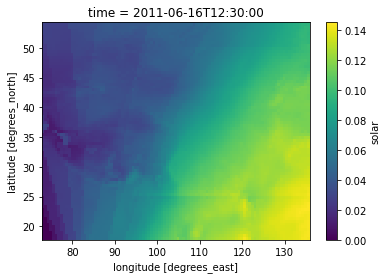

In [14]:
combine['Anhui']['solar'].plot()

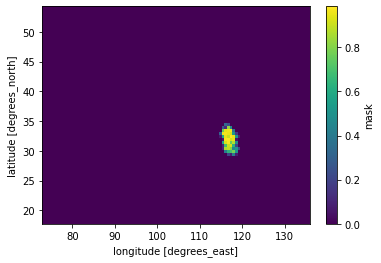

In [15]:
combine['Anhui']['mask'].plot()

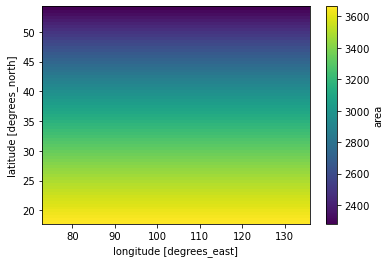

In [16]:
combine['Anhui']['area'].plot()